# Harmony EOSS L2SS API Tutorial

This notebook will demonstrate how to subset Level 2 data using a sea surface temperature product from the following collection: MODIS_A-JPL-L2P-v2019.0, GHRSST Level 2P Global Sea Surface Skin Temperature from the Moderate Resolution Imaging Spectroradiometer (MODIS) on the NASA Aqua satellite (GDS2).

## Before you start

Before you beginning this tutorial, make sure you have an account in the Earthdata Login, which is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register for an Earthdata Login account. It is free to create and only takes a moment to set up.

You will also need a netrc file containing your NASA Earthdata Login credentials in order to execute this notebook. A netrc file can be created manually within text editor and saved to your home directory. For additional information see: [Authentication for NASA Earthdata](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/04_NASA_Earthdata_Authentication.html#authentication-via-netrc-file).

In [1]:
from harmony import BBox, Client, Collection, Request, Environment, LinkType
from urllib import request
from http.cookiejar import CookieJar
import tempfile
import getpass
import netrc
import json
import requests
import sys
import shutil
import xarray as xr

### Find a granule for subsetting

Below we call out a specific granule (G2524986524-POCLOUD) on which we will use the podaac L2 subsetter. Finding this information would complicate the tutorial- but po.daac has a tutorial available for using the CMR API to find collections and granules of interest. Please see [this tutorial](https://github.com/podaac/tutorials/blob/master/notebooks/podaac_cmr_tutorial.ipynb) for that information.


In [2]:
collection = 'C1940473819-POCLOUD'
variable = 'sea_surface_temperature'
venue = 'prod'

In [3]:
# Defaults
cmr_root = 'cmr.earthdata.nasa.gov'
harmony_root = 'https://harmony.earthdata.nasa.gov'
edl_root = 'urs.earthdata.nasa.gov'

##  Subset of a PO.DAAC Granule

We can now build onto the root URL in order to actually perform a transformation.  The first transformation is a subset of a selected granule.  _At this time, this requires discovering the granule id from CMR_.  That information can then be appended to the root URL and used to call Harmony with the help of the `request` library.

Above we show how to find a granule id for processing.

**Notes:**
  The L2 subsetter current streams the data back to the user, and does not stage data in S3 for redirects. This is functionality we will be adding over time.
  It doesn't work with URS backed files, which is coming in the next few weeks
  it only works on the show dataset, but 
    

In [4]:
cmr_url = "https://"+cmr_root+"/search/granules.umm_json?collection_concept_id="+collection+"&sort_key=-start_date&bounding_box=-90,-45.75,90,-45"

response = requests.get(cmr_url)

gid=response.json()['items'][0]['meta']['concept-id']
print(response.json()['items'][0])
print(gid)


{'meta': {'concept-type': 'granule', 'concept-id': 'G2525170373-POCLOUD', 'revision-id': 3, 'native-id': '20221025185001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0', 'provider-id': 'POCLOUD', 'format': 'application/vnd.nasa.cmr.umm+json', 'revision-date': '2022-10-25T21:12:59.142Z'}, 'umm': {'TemporalExtent': {'RangeDateTime': {'EndingDateTime': '2022-10-25T18:54:58.000Z', 'BeginningDateTime': '2022-10-25T18:50:01.000Z'}}, 'MetadataSpecification': {'URL': 'https://cdn.earthdata.nasa.gov/umm/granule/v1.6.4', 'Name': 'UMM-G', 'Version': '1.6.4'}, 'GranuleUR': '20221025185001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0', 'ProviderDates': [{'Type': 'Insert', 'Date': '2022-10-25T21:10:17.165Z'}, {'Type': 'Update', 'Date': '2022-10-25T21:10:17.165Z'}], 'SpatialExtent': {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -85.928, 'NorthBoundingCoordinate': -26.101, 'EastBoundingCoordinate': -54.117, 'SouthBoundingCoordinate': -47.37}], 'GPolygons':

In [5]:
harmony_client = Client(env=Environment.PROD)

collection_id = Collection(collection) 

request = Request(
    collection=collection_id,
    spatial=BBox(-90,-45.75,90,45), #  lat: (-45.75:45), lon: (-90:90)
    granule_id=gid 
)

request.is_valid()

True

In [6]:
# sumbit request and monitor job
job_id = harmony_client.submit(request)
print('\n Waiting for the job to finish. . .\n')
response = harmony_client.result_json(job_id, show_progress=True)
print("\n. . .DONE!")


 Waiting for the job to finish. . .



 [ Processing: 100% ] |###################################################| [|]



. . .DONE!


In [7]:
temp_dir = tempfile.mkdtemp()
futures = harmony_client.download_all(job_id, directory=temp_dir, overwrite=True)
file_names = [f.result() for f in futures]
file_names

['C:\\Users\\nickles\\AppData\\Local\\Temp\\tmp2hna47qz\\20221025185001-JPL-L2P_GHRSST-SSTskin-MODIS_A-D-v02.0-fv01.0_subsetted.nc4']

In [8]:
ds = xr.open_dataset(file_names[0])
ds

lat_var = None
lon_var = None

# Determine the lat/lon coordinate names
for coord_name, coord in ds.coords.items():
    if 'units' not in coord.attrs:
        continue
    if coord.attrs['units'] == 'degrees_north':
        lat_var = coord_name
    if coord.attrs['units'] == 'degrees_east':
        lon_var = coord_name
        
# If the lat/lon coordinates could not be determined, use l2ss-py get_coord_variable_names
if not lat_var or not lon_var:
    from podaac.subsetter import subset
    lat_var_names, lon_var_names = subset.get_coord_variable_names(ds)
    lat_var = lat_var_names[0]
    lon_var = lon_var_names[0]

print(f'lat_var={lat_var}')
print(f'lon_var={lon_var}')

lat_var=lat
lon_var=lon


In [9]:
if ds[variable].size == 0:
    print("No data in subsetted region. Exiting")
    sys.exit(0)

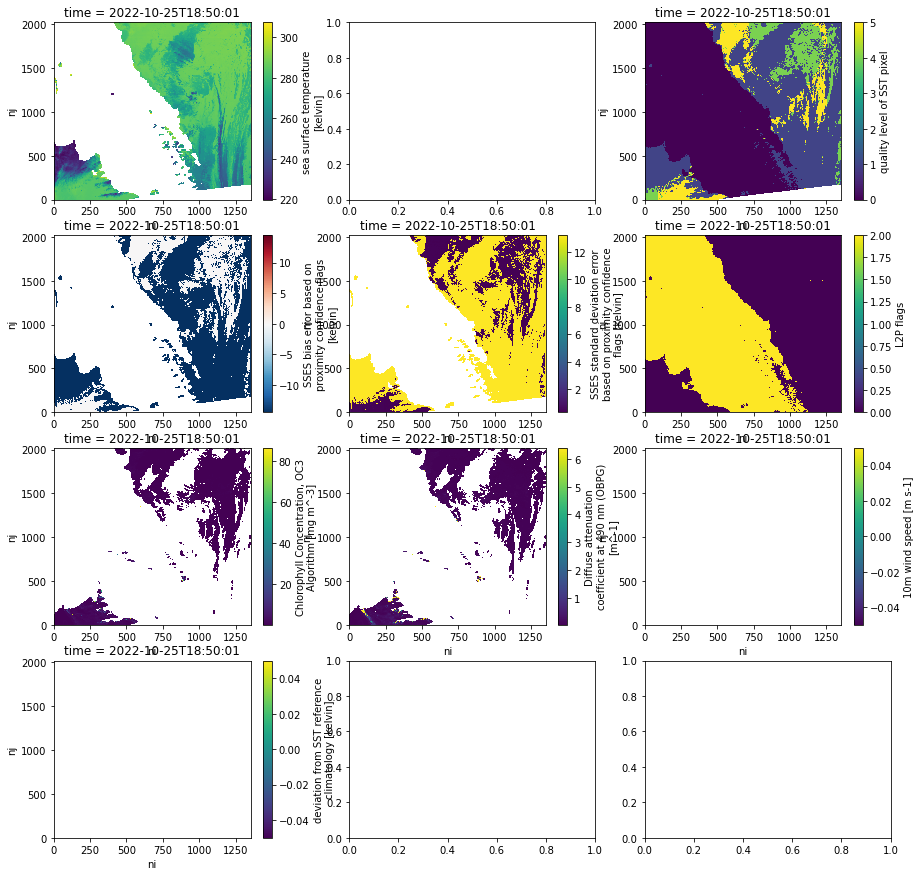

In [10]:
import matplotlib.pyplot as plt
import math

fig, axes = plt.subplots(ncols=3, nrows=math.ceil((len(ds.data_vars)/3)))
fig.set_size_inches((15,15))

for count, xvar in enumerate(ds.data_vars):
    if  ds[xvar].dtype == "timedelta64[ns]":
        continue
        #ds[xvar].astype('timedelta64[D]').plot(ax=axes[int(count/3)][count%3])
    ds[xvar].plot(ax=axes[int(count/3)][count%3])

## Verify the subsetting worked

Bounds used were: 

  'lat': '(-45.75:45)',
  'lon': '(-90:90)'

In [11]:
var_ds = ds[variable]
msk = xr.ufuncs.logical_not(xr.ufuncs.isnan(var_ds.data.squeeze()))

llat = ds[lat_var].where(msk)
llon = ds[lon_var].where(msk)

lat_max = llat.max()
lat_min = llat.min()

lon_min = llon.min()
lon_max = llon.max()

lon_min = (lon_min + 180) % 360 - 180
lon_max = (lon_max + 180) % 360 - 180

print(lon_min)
print(lon_max)
print(lat_min)
print(lat_max)

if lat_max <= 45 and lat_min >= -45.75:
    print("Successful Latitude subsetting")
elif xr.ufuncs.isnan(lat_max) and xr.ufuncs.isnan(lat_min):
    print("Partial Lat Success - no Data")
else:
    assert False


if lon_max <= 90 and lon_min >= -90:
    print("Successful Longitude subsetting")
elif xr.ufuncs.isnan(lon_max) and xr.ufuncs.isnan(lon_min):
    print("Partial Lon Success - no Data")
else:
    assert False
    

<xarray.DataArray 'lon' ()>
array(-85.92834473)
<xarray.DataArray 'lon' ()>
array(-54.11688995)
<xarray.DataArray 'lat' ()>
array(-45.74999237)
<xarray.DataArray 'lat' ()>
array(-27.91536331)
Successful Latitude subsetting
Successful Longitude subsetting
